<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/Testing_Pre_trained_Model_Binary_False_Positive_Case_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import re
import spacy
from gensim import corpora, models
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
nlp = spacy.load("en_core_web_sm")

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.14.0
GPU is NOT AVAILABLE


In [2]:
# Specify the path to the CSV file
csv_file_path = '/content/true_positive_experimentation.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Extract the text data from the 'text' column
text_data = df['doc_text_original'].tolist()

<ipython-input-2-96e57bab995a>:5: DtypeWarning: Columns (1,2,3,4,5,10,15,16,17,21,22,30,32,34,35,36,37,40,43,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


In [4]:
def preprocess_text(text):
    if not isinstance(text, str):
        # Handle non-string elements here, for example, by returning an empty string
        return ""

    # Remove special characters using regular expressions
    text = re.sub(r'[^\w\s]', '', text)

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(tokens)

# Apply preprocessing to the DataFrame, including removing NaN values
df['preprocessed_data'] = df['doc_text_original'].apply(preprocess_text)

# Filter out rows with empty strings (resulting from non-string elements)
df = df[df['preprocessed_data'] != ""]

# Filter out non-string elements from text_data and preprocess the rest
preprocessed_data = [preprocess_text(text) for text in text_data if isinstance(text, str)]

In [5]:
# Testing with pre-trained model

# Load the pre-trained model from TensorFlow Hub
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
# embedding = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=False)

# Flatten and join the tokenized data into a single string for each document
X_test = [" ".join(doc) for doc in preprocessed_data]

# Create a binary classification model by adding a dense layer with sigmoid activation
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Load pre-trained weights (if available)
# model.load_weights("path_to_pretrained_weights.h5")

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Make predictions on your test data
predictions = model.predict(X_test)

# Assuming predictions are probability scores, you can threshold them to get binary predictions
binary_predictions = (predictions > 0.5).astype(np.int32)

3/3 [==============================] - 0s 5ms/step


In [6]:
# Assuming 'binary_predictions' contains your binary predictions
# Ensure that the length of 'binary_predictions' matches the number of rows you want to update
num_rows_to_update = len(binary_predictions)

# Update the "predicted_label_code" column with the binary predictions for the first 'num_rows_to_update' rows
df.loc[:num_rows_to_update - 1, 'predicted_label_code'] = binary_predictions

# Now, 'df' should have the "predicted_label_code" column filled with the predictions for the specified number of rows


<ipython-input-6-065a4ea32a7f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:num_rows_to_update - 1, 'predicted_label_code'] = binary_predictions
<ipython-input-6-065a4ea32a7f>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:num_rows_to_update - 1, 'predicted_label_code'] = binary_predictions


In [7]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'

# Calculate accuracy
correct_predictions = (df['label_code'] == df['predicted_label_code']).sum()
total_predictions = len(preprocessed_data)
accuracy = (correct_predictions / total_predictions) * 100

print(f"Number of correct predictions: {correct_predictions}")

print(f"Accuracy: {accuracy:.2f}%")


Number of correct predictions: 58
Accuracy: 62.37%


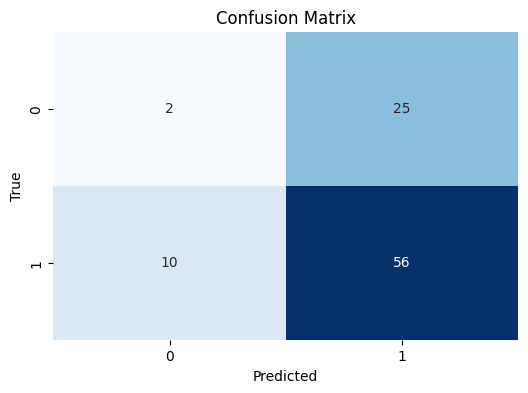

Accuracy: 0.62
Precision: 0.69
Recall: 0.85
F1 Score: 0.76


In [8]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted_label_code']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

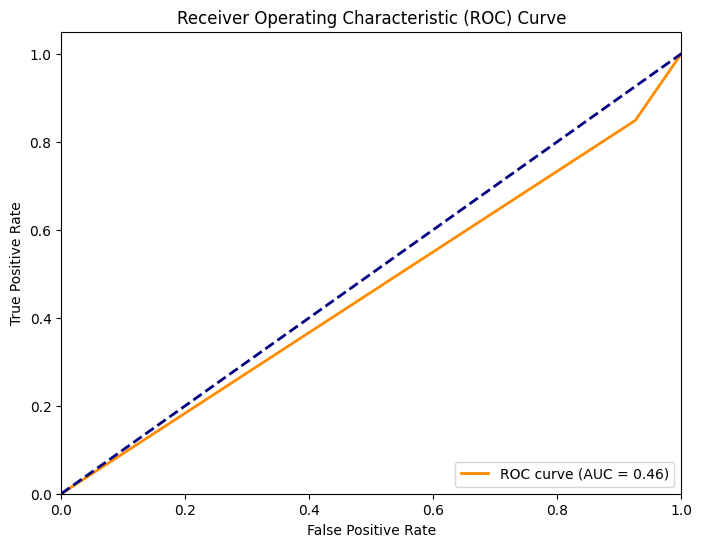

In [9]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_score = df['predicted_label_code']  # This should contain the predicted probabilities or scores

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [10]:
# Assuming you have your DataFrame 'df' with the updates

# Specify the file path where you want to save the CSV file
output_csv_file = "true_positive_updated.csv"

# Save the DataFrame to a new CSV file
df.to_csv(output_csv_file, index=False)

print(f"DataFrame saved to {output_csv_file}")


DataFrame saved to true_positive_updated.csv
